In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
!git clone https://github.com/superring/topic_model.git
!pip install -r ./topic_model/requirements.txt

Cloning into 'topic_model'...
remote: Enumerating objects: 8363, done.
remote: Counting objects: 100% (8363/8363), done.
remote: Compressing objects: 100% (8261/8261), done.
remote: Total 8363 (delta 98), reused 8352 (delta 90), pack-reused 0
Receiving objects: 100% (8363/8363), 31.84 MiB | 24.15 MiB/s, done.
Resolving deltas: 100% (98/98), done.
     |████████████████████████████████| 829kB 34.2MB/s 
     |████████████████████████████████| 23.9MB 2.0MB/s 
     |████████████████████████████████| 122kB 53.3MB/s 
     |████████████████████████████████| 788kB 42.5MB/s 
     |████████████████████████████████| 143kB 48.8MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 122kB 50.3MB/s 
     |████████████████████████████████| 13.1MB 256kB/s 
     |████████████████████████████████| 491kB 43.0MB/s 
     |████████████████████████████████| 552kB 37.9MB/s 
     |████████████████████████████████| 9.5MB 33.2MB/s 
     |███████████████████████████████

In [2]:
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.3
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
  swig3.0
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl lib

In [3]:
import glob
import urllib
import MeCab
import subprocess
import gensim
import math
import matplotlib
import matplotlib.pylab as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings
warnings.filterwarnings('ignore')
FONT = "./topic_model/ArialUnicodeMS.ttf"

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
# テキストファイルのパス
# ファイル要件：改行で文書を区切る；utf-8でエンコードされている。
text_path = './topic_model/simple_input.tsv' #　ここのパスを変更することで任意のファイルを処理可能

# 形態素解析用のストップワードの定義
req = urllib.request.Request('http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt')
with urllib.request.urlopen(req) as res:
    stopwords = res.read().decode('utf-8').split('\r\n')
while '' in stopwords:
    stopwords.remove('')

In [5]:
# 形態素解析用の関数定義。固有名詞、名詞、動詞、形容詞を中心に
def analyzer(text, mecab, stopwords=[], target_part_of_speech=['proper_noun', 'noun', 'verb', 'adjective']):

    node = mecab.parseToNode(text)
    words = []

    while node:

        features = node.feature.split(',')
        surface = features[6]

        if (surface == '*') or (len(surface) < 2) or (surface in stopwords):
            node = node.next
            continue

        noun_flag = (features[0] == '名詞')
        proper_noun_flag = (features[0] == '名詞') & (features[1] == '固有名詞')
        verb_flag = (features[0] == '動詞') & (features[1] == '自立')
        adjective_flag = (features[0] == '形容詞') & (features[1] == '自立')


        if ('proper_noun' in target_part_of_speech) & proper_noun_flag:
            words.append(surface)
        elif ('noun' in target_part_of_speech) & noun_flag:
            words.append(surface)
        elif ('verb' in target_part_of_speech) & verb_flag:
            words.append(surface)
        elif ('adjective' in target_part_of_speech) & adjective_flag:
            words.append(surface)

        node = node.next

    return words

In [7]:
# LDAのための辞書とコーパス作成
cmd = 'echo `mecab-config --dicdir`"/mecab-ipadic-neologd"'
path = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                           shell=True).communicate()[0]).decode('utf-8')
mecab = MeCab.Tagger("-d {0}".format(path))

text = open(text_path, 'r', encoding='utf-8').read()

texts_words = {}

# 記事単位：改行で区切る
text = text.split('\n')
# 文章単位：句読点で区切る
# text = text.replace('\n', '。')
# text = text.split('。')
for i, t in enumerate(text):
    texts_words[i] = [w for w in analyzer(t, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])]

dictionary = gensim.corpora.Dictionary(texts_words.values())
#dictionary.filter_extremes(no_above=0.3)
dictionary.filter_n_most_frequent(5)
corpus = [dictionary.doc2bow(words) for words in texts_words.values()]

# # tfidfを計算
# tfidf = gensim.models.TfidfModel(corpus)
# # tfidfのコーパスを作成
# corpus_tfidf = tfidf[corpus]

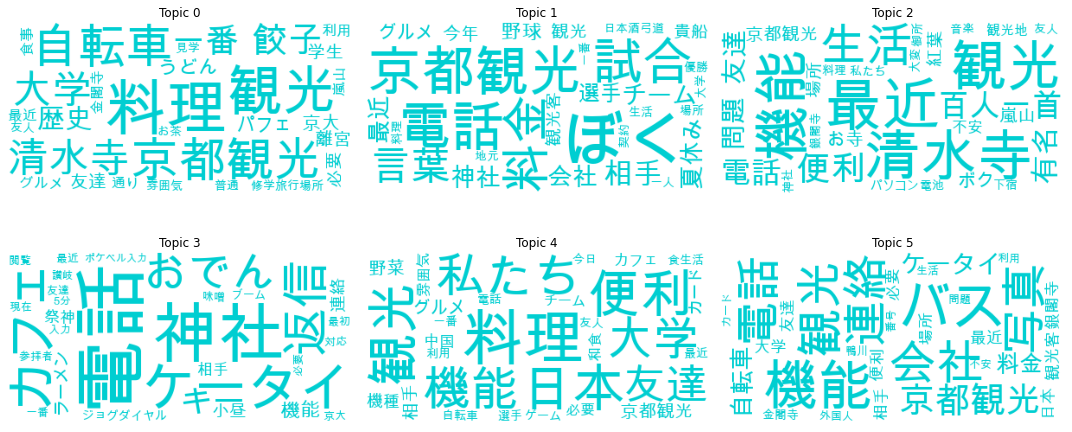

In [8]:
# LDAの実行
num_topics = 6
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=0)

# 可視化
ncols = math.ceil(num_topics/2)
nrows = math.ceil(lda_model.num_topics/ncols)
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,7))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i in range(lda_model.num_topics):

    x = dict(lda_model.show_topic(i, 30))
    im = WordCloud(
        font_path=FONT,
        background_color='white',
        color_func=color_func,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(i))

plt.tight_layout()
plt.savefig("./visualize.png")

In [ ]:
# pyLDAvisによる可視化
vis = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(vis, './pyldavis_output_simple.html')

In [ ]:
# 予測用関数の定義
def topic_prediction(string_input):

    # Fit and transform
    words = analyzer(string_input, mecab, stopwords=stopwords, target_part_of_speech=['noun', 'proper_noun'])
 
    # コーパス作成
    corpus = [dictionary.doc2bow(words)]
#     # tfidfを計算
#     tfidf = gensim.models.TfidfModel(corpus)
#     # tfidfのコーパスを作成
#     corpus_tfidf = tfidf[corpus]
 
    output = list(lda_model[corpus])[0]
    topics = sorted(output,key=lambda x:x[1],reverse=True)
    return topics[0][0]
    #return output

In [ ]:
# 予測
topic_prediction("昨日京都の金閣寺と銀閣寺に行って、稲荷大社にも行きました。")

5